<a href="https://colab.research.google.com/github/abhagyacharan/Stable-Diffusion/blob/main/Stable_Diffusion_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [3]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 23.9 MB/s eta 0:00:00


In [4]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [20]:
unet.to('cuda')

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [21]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4",
subfolder="scheduler")

In [22]:
!pip install torchvision

In [23]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [24]:
import torch

In [25]:
prompt = [" an astronaut riding a horse"]


height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion


num_inference_steps = 100            # Number of denoising steps


guidance_scale = 7.5                # Scale for classifier-free guidance


generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise


batch_size = 1


In [28]:
import torch

# Set the device to GPU (if available) or fallback to CPU
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# Tokenize the prompt
text_input = tokenizer(prompt, padding="max_length",
  max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

# Move input tensors to the correct device
text_input = {k: v.to(torch_device) for k, v in text_input.items()}

# Move the text_encoder model to the correct device
text_encoder = text_encoder.to(torch_device)

# Encode with the text_encoder on the specified device
with torch.no_grad():
  text_embeddings = text_encoder(text_input["input_ids"])[0]


In [30]:
# Get the max length of input ids
max_length = text_input['input_ids'].shape[-1]  # Access the 'input_ids' key explicitly

# Create unconditional input for batch_size, using empty string
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

# Move unconditional input tensors to the correct device
uncond_input = {k: v.to(torch_device) for k, v in uncond_input.items()}

# Compute the unconditional embeddings
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input['input_ids'])[0]  # Access the 'input_ids' key explicitly


In [31]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [33]:
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),generator=generator,)

latents = latents.to(torch_device)

<ipython-input-33-ed24a12a0c08>:1: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),generator=generator,)


In [34]:
scheduler.set_timesteps(num_inference_steps)

latents = latents * scheduler.init_noise_sigma

In [43]:
!pip install tqdm

In [41]:
print(scheduler)
print(dir(scheduler))  # This will list all the available methods and attributes

LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.30.3",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false
}

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_begin_index', '_compatibles', '_convert_to_karras', '_deprecated_kwargs', '_dict_from_json_file', '_get_compatibles', '_get_init_keys', '_init_step_index', '_internal_dict', '_sigma_to_t', '_st

In [46]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear"
)


In [49]:
!pip3 install tqdm

In [50]:
from tqdm import tqdm
from torch import autocast

# Assuming your `scheduler.step` function is correct in the implementation

for t in tqdm(scheduler.timesteps):

    # Expand the latents for classifier-free guidance
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform classifier-free guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample  # Ensure `step` is callable


100%|██████████| 1000/1000 [08:14<00:00,  2.02it/s]


In [54]:
!pip3 install pillow

In [58]:
# Scale and decode the image latents with VAE
latents = 1 / 0.18215 * latents

# Move VAE model to the correct device (GPU, if latents are on the GPU)
vae = vae.to(latents.device)  # This ensures the VAE is on the same device as latents

with torch.no_grad():
    image_tensor = vae.decode(latents).sample


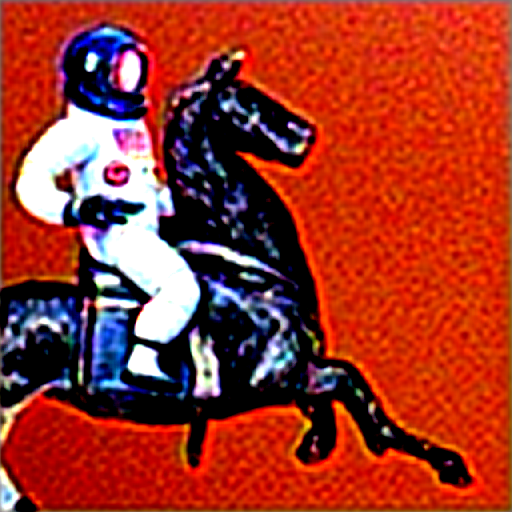

In [59]:
import torch
from PIL import Image

# Assume `image_tensor` is a PyTorch tensor
# Perform operations on the PyTorch tensor
image_tensor = (image_tensor / 2 + 0.5).clamp(0, 1)  # Clamping on the tensor

# Now convert the tensor to a NumPy array after all tensor operations are done
image_array = image_tensor.detach().cpu().permute(0, 2, 3, 1).numpy()  # Use a different name for NumPy array

# Convert the image to uint8 type
images = (image_array * 255).round().astype("uint8")  # Working on NumPy array now

# Convert NumPy arrays to PIL images
pil_images = [Image.fromarray(img) for img in images]  # Using 'img' for the loop variable

# Show the first image
pil_images[0]
